# Codeando un Transformer!

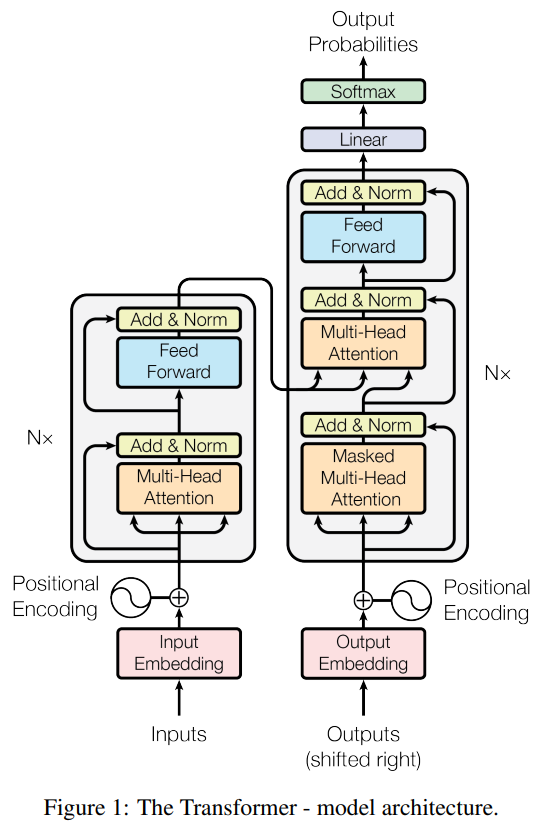

## Introducción
Al fin! Lo que todos estábamos esperando. Ahora que sabemos como funciona el mecanismo de Attention tenemos casi todos los componentes que hacen falta para construir un Transformer (la T en GPT). A pesar de los memes que andan dando vuelta, no tienen ninguna relación con los dibujitos. Se llaman Transformers por que en el paper *Attention is all you need* se usan para transformar texto, de un idioma a otro.

Vamos a estar creando algunos transformers pequeños, de algunos cientos de miles de parámetros. Es posible replicar esta parte usando solo CPU, aunque puede llevar algo más de tiempo. El ejemplo del final es un transformer con 7.27 millones de parámetros. Para entrenar este transformer si es necesario usar GPU (entrenar en CPU solo es posible pero lleva días). Usando una GPU de notebook (NVIDIA 1660 TI mobile 6 GB VRAM) se logran 1000 steps en 7.5 minutos (hacer 10K steps lleva cerca de una hora y media). Para aquellos que no puedan replicar esta parte del código, voy a hacer disponibles algunos modelos pre-entrenados los cuales pueden cargar para hacer inferencia usando solo CPU sin problemas.

Esta clase está dividida en seis secciones:
1. Vamos a cambiar la forma de samplear los datos de entrenamiento respecto a la forma que veniamos haciendo. Esto es necesario para poder entrenar el transformer pero además nos va a permitir cambiar el texto de entrenamiento más fácilmente.
2. Vamos a crear todos los componentes de la primer versión del transformer usando los modulos que habíamos creado. Necesitamos Linear, Tanh, Embedding, BatchNorm. Además vamos a implementar Dropout, LayerNorm, SelfAttention, MultiHead Self Attention y el Transformer Block.
3. Vamos a cambiar el algoritmo de optimización de SGD a Adam usando `torch.optim`.
4. Vamos a reescribir los componentes del transformer usando `nn.Module` de torch.
5. Vamos a agrandar el modelo y entrenar usando otros datasets.
6. Voy es extenderme en algunas conclusiones y notas antes de presentarles los ejercicios.

Follow me!

## Código inicial - leyendo texto del dataset.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [ ]:
import idna

def punyencode(text: str) -> str:
    """Encodes a UTF-8 string to its Punycode representation, handling spaces by encoding each word separately."""
    
    return " ".join([idna.encode(word).decode('ascii') for word in text.split()])
    
def punydecode(punycode: str) -> str:
    """Decodes a Punycode string back to UTF-8."""
    return " ".join([idna.decode(word) for word in punycode.split()])

def process_name(name):
    name = name.lower()
    for n in name.split():
        if len(n) < 2:
            return ''
    try:
        return punyencode(name)
    except:
        return ''

dataset = open("data/city_names_full.txt", 'r').read().split('\n')
with open('data/city_names_puny.txt', 'w') as f:
    for n in dataset:
        name = process_name(n)
        if name != '':
            f.write(name+'\n')
dataset = open("data/city_names_puny.txt", 'r').read().split('\n')
puny = [x for x in dataset if 'xn--' in x]
nopuny = [x for x in dataset if 'xn--' not in x]

### Definiendo hiperparámetros

In [ ]:
# -----  Hiperparámetros del modelo
context_size = 128
emb_size = 64
n_hidden = 128
att_head_size = 256
num_heads = 8
num_blocks = 3
dropout = 0.2

# ----- Parámetros de training
batch_size = 64
steps = 20001
eval_interval = 100
learning_rate = 1e-3
eval_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Los componentes básicos

### El modelo

### Mejorando el optimizador

In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(context_size, context_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C **-.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_head, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(n_embd, head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class TransformerDecoderBlock(nn.Module):
    def __init__(self, n_head, n_embd):
        super().__init__()
        head_size = n_embd // n_head     # el tamaño del embedding debe ser multiplo de la cantidad de heads
        self.sa = MultiHeadAttention(n_head, n_embd, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


## Migrando a PyTorch

## Agrandando el modelo

In [ ]:
# -----  Hiperparámetros del modelo
context_size = 256
emb_size = 384
num_heads = 6
num_blocks = 4
dropout = 0.2

# ----- Parámetros de training
batch_size = 64
steps = 10001
eval_interval = 100
learning_rate = 1e-3
steps = 10001
eval_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Salvando y restaurando el modelo

# Conclusiones
* Decoder only y diferencias con Encoder/Decoder.
* LMs overfitting y compresión de la entrada.
* Char level vs Token level
* Modelo fundacional vs Finetuning con RLHF vs Asistente
* Llama embeddings (RoPE)
* Mixture of Experts (MoE)
* Deepseek Transformers (MLA multiheat lattent attention)
* Como seguir con esto?

# Ejercicios
